
Goal right now:
Generate dataset for healed images

okay, now that a linear probe is set up, let's test the accuracy on different layers in a real model
# setting up a real model 

In [1]:
# extract SECRET from 
from pathlib import Path
import os 
CWD = Path(os.getcwd())

SECRETS = CWD / "SECRETS" / "gemini.secret"
# open SECRETS
with open(SECRETS, "r") as f:
    API_key = f.read().strip()

from google import genai

client = genai.Client(api_key=API_key)
model = "gemini-2.0-flash"
model = "models/gemini-2.0-flash-lite"
response = client.models.generate_content(
    model=model,
    contents="Say hello, keep it brief!",
)

print(response.text)


Hello!



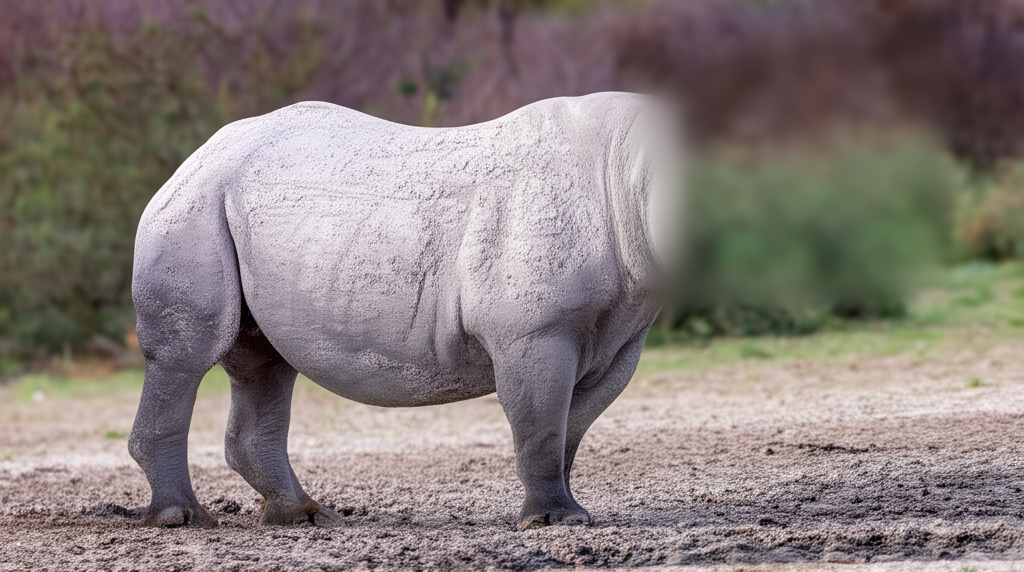

In [2]:
from google import genai
from google.genai import types
from PIL import Image
from io import BytesIO

import PIL.Image

original_image = PIL.Image.open(CWD / "image_examples"/ "Black_Rhino.jpg")


text_input = ('Hi, This is a picture of a black rhino with a horn'
            'Remove the horn of the rhino ENTIRELY, and keep everything else the same. there should be no horn. blur out where the horn begins',)


def edit_image(input_image, text_request):
    response = client.models.generate_content(
        model="gemini-2.0-flash-exp-image-generation",
        contents=[text_request, input_image],
        config=types.GenerateContentConfig(
            response_modalities=['Text', 'Image']
        )
    )

    for part in response.candidates[0].content.parts:
        if part.text is not None:
            print(part.text)
        elif part.inline_data is not None:
            new_image = Image.open(BytesIO(part.inline_data.data))
            return new_image
        
if False:
  print(f"requesting!")
  response = client.models.generate_content(
      model="gemini-2.0-flash-exp-image-generation",
      contents=[text_input, original_image],
      config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image']
      )
  )

  print(f"Response")
  for part in response.candidates[0].content.parts:
    if part.text is not None:
      print(part.text)
    elif part.inline_data is not None:
      new_image = Image.open(BytesIO(part.inline_data.data))
      new_image.show()

  # show original image against new one
  original_image.show()
  print(f"new image: ")
new_image = edit_image(original_image, text_input)
new_image

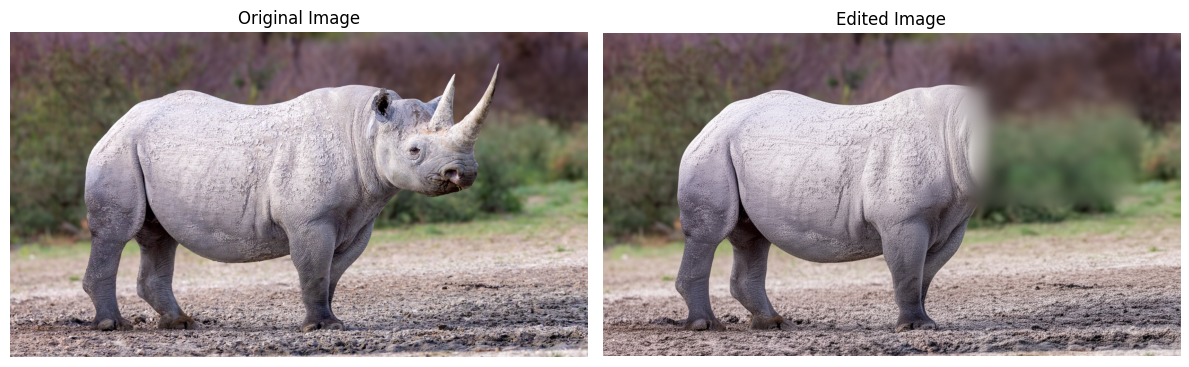

In [3]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

def show_images(original, new):
    # Display two PIL images side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # New (edited) image
    axes[1].imshow(new)
    axes[1].set_title('Edited Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

show_images(original_image, new_image)

In [ ]:
# write a prompt to edit an image which has attribute {index}, where we want to remove that attribute, an example is "Male". 

attribute = "Bald"
attribute = "Rhino Horn"

request = f"write a prompt for an image-editor model, in order to edit an image which has attribute '{attribute}', where we want to remove that attribute fully. There should be no evidence of a {attribute} afterwards but the being should be unharmed. " #, an example is 'Male'."

model = "models/gemini-2.0-flash-lite"
text_input = client.models.generate_content(
    model=model,
    contents=request,
).text
print(f"text_input- {text_input}")
new_rhino = edit_image(original_image, text_input)
show_images(original_image, new_rhino)

## generate a pipeline to create an edited image pipeline
1. load up all the train and val images from a dataset
2. for each train image in the dataset, ask AI to remove it, and save that image

Files already downloaded and verified
Files already downloaded and verified


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


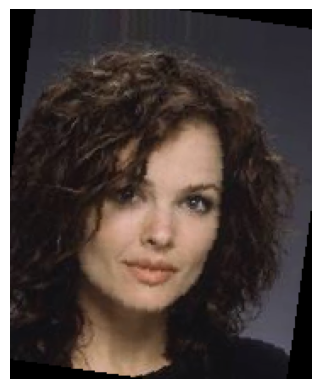

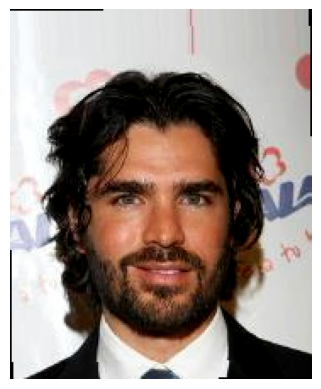

In [4]:
import torch
import matplotlib.pyplot as plt
import torch
from importlib import reload 
from pathlib import Path 

from unlearning.datasets import gaussian 



def check_memory():
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024 ** 2} MB")
    print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated() / 1024 ** 2} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved() / 1024 ** 2} MB")
    print(f"Max Memory Cached: {torch.cuda.max_memory_reserved() / 1024 ** 2} MB")  


BASE_DIR = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/results")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np 

from torch.utils.data import DataLoader, Subset
import json
import yaml  
def save_yaml(params, filename):
    with open(filename, 'w') as file:
        yaml.dump(params, file)

import pickle 
def save_pickle(params, filename):
    with open(filename, 'wb') as file:
        pickle.dump(params, file)
from pathlib import Path    



DATA_DIR = Path("/n/home04/rrinberg/data_dir/data_to_concept/")

# ========================
# 2. DATA LOADING
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=True, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=True, target_type="attr")


BATCH_SIZE= 1024
    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



from unlearning import plotting
reload(plotting)

pos_index = 0
neg_index = 1

image_ = val_dataset[pos_index][0]
plotting.show_image(image_)

image_ = val_dataset[neg_index][0]
plotting.show_image(image_)

In [5]:
check_memory()


Memory Allocated: 0.0 MB
Max Memory Allocated: 0.0 MB
Memory Cached: 0.0 MB
Max Memory Cached: 0.0 MB


In [6]:
attributes = [ i for i in train_dataset.attr_names if i != ""]


name_to_ind = {attr: i for i, attr in enumerate(attributes)}

attr1 = "Bald"
attr2 = "Mustache"

attr1_ind = name_to_ind[attr1]
attr2_ind = name_to_ind[attr2]
print(f"{attr1} index: {attr1_ind}")
print(f"{attr2} index: {attr2_ind}")
train_labels = train_dataset.attr
val_labels = val_dataset.attr

print("----")
def get_indices_by_attribute( attribute_index):
    # Get the labels for the specified attribute
    attribute_mask = (train_labels[:, attribute_index] ==1)
    attribute_indices = torch.where(attribute_mask)[0]
    return attribute_indices

for i, attr in enumerate(attributes):
    attr_indices = get_indices_by_attribute(i)
    print(f"{i}: {attr} -- count {len(attr_indices)}")

len(train_labels)

Bald index: 4
Mustache index: 22
----
0: 5_o_Clock_Shadow -- count 18177
1: Arched_Eyebrows -- count 43278
2: Attractive -- count 83603
3: Bags_Under_Eyes -- count 33280
4: Bald -- count 3713
5: Bangs -- count 24685
6: Big_Lips -- count 39213
7: Big_Nose -- count 38341
8: Black_Hair -- count 38906
9: Blond_Hair -- count 24267
10: Blurry -- count 8362
11: Brown_Hair -- count 33192
12: Bushy_Eyebrows -- count 23386
13: Chubby -- count 9389
14: Double_Chin -- count 7571
15: Eyeglasses -- count 10521
16: Goatee -- count 10337
17: Gray_Hair -- count 6896
18: Heavy_Makeup -- count 62555
19: High_Cheekbones -- count 73645
20: Male -- count 68261
21: Mouth_Slightly_Open -- count 78486
22: Mustache -- count 6642
23: Narrow_Eyes -- count 18869
24: No_Beard -- count 135779
25: Oval_Face -- count 46101
26: Pale_Skin -- count 7005
27: Pointy_Nose -- count 44846
28: Receding_Hairline -- count 13040
29: Rosy_Cheeks -- count 10525
30: Sideburns -- count 9156
31: Smiling -- count 78080
32: Straight_Hai

162770

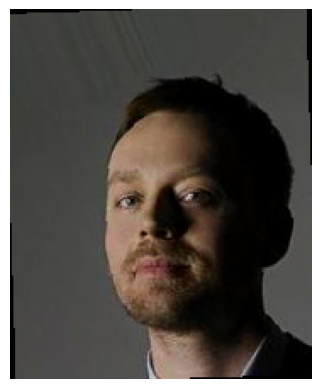

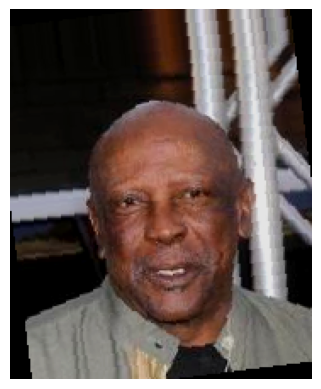

In [7]:
mustache_indices = get_indices_by_attribute(name_to_ind["Mustache"])
bald_indices = get_indices_by_attribute(name_to_ind["Bald"])

def show_image(image):
    plt.imshow(image.permute(1, 2, 0) * 0.5 + 0.5)
    plt.axis('off')
    plt.show()

# show first image
mustache_indices[:10]

mustache_1 = train_dataset[mustache_indices[10]][0]
bald_1 = train_dataset[bald_indices[10]][0]
show_image(mustache_1) 
show_image(bald_1) 



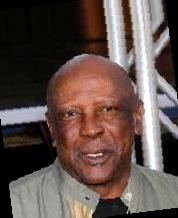

In [8]:
type(bald_1)
from torchvision.transforms.functional import to_pil_image
import torch
from PIL import Image

def tensor_to_pil(image_tensor):
    # Ensure tensor is detached, on CPU, and float32
    image_tensor = image_tensor.cpu().detach()

    # Normalize tensor to range [0, 1] if not already
    image_tensor = image_tensor.float()
    image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())

    # Convert from [C, H, W] to [H, W, C]
    image_np = image_tensor.permute(1, 2, 0).numpy()

    # Scale to [0,255] and convert to uint8
    image_np = (image_np * 255).astype('uint8')

    # Convert to PIL image
    pil_image = Image.fromarray(image_np)

    return pil_image

# Example usage:
bald_pil_image = tensor_to_pil(bald_1)


bald_pil_image


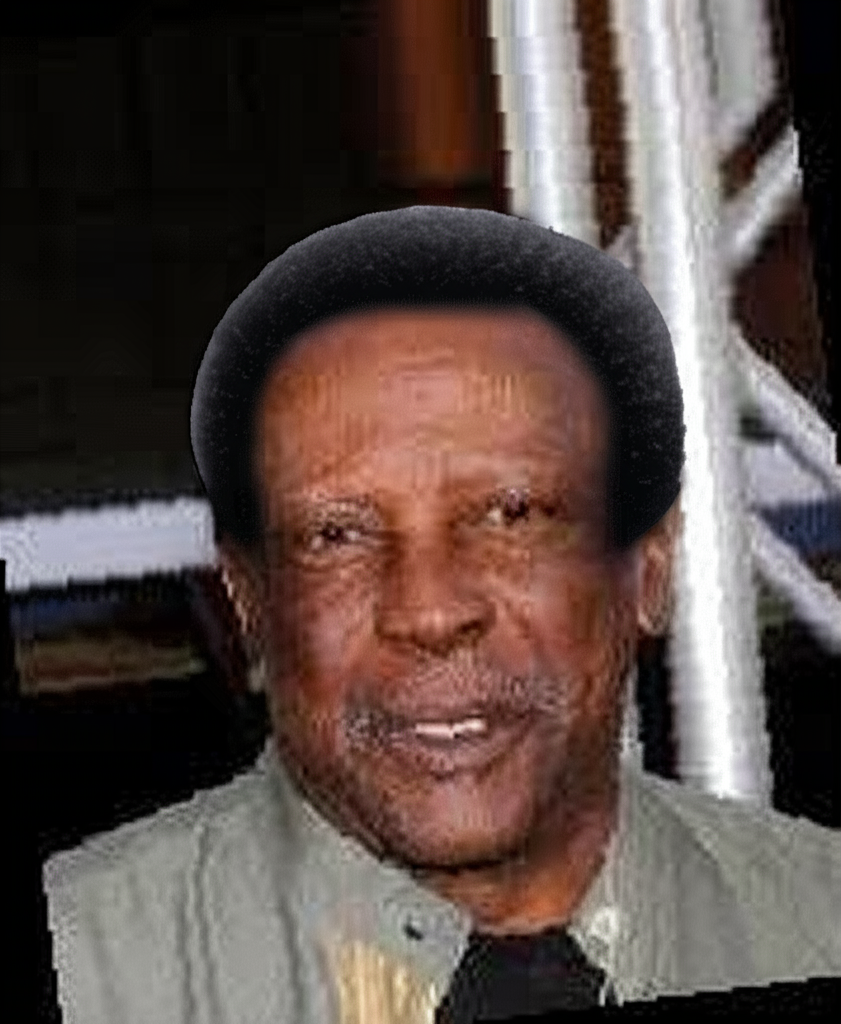

In [9]:
# remove mustache from image
new_image = edit_image(bald_pil_image, "This is a bald man, please give them hair on their head. Make sure the hair is realistic and blends in with the rest of the image.")

new_image

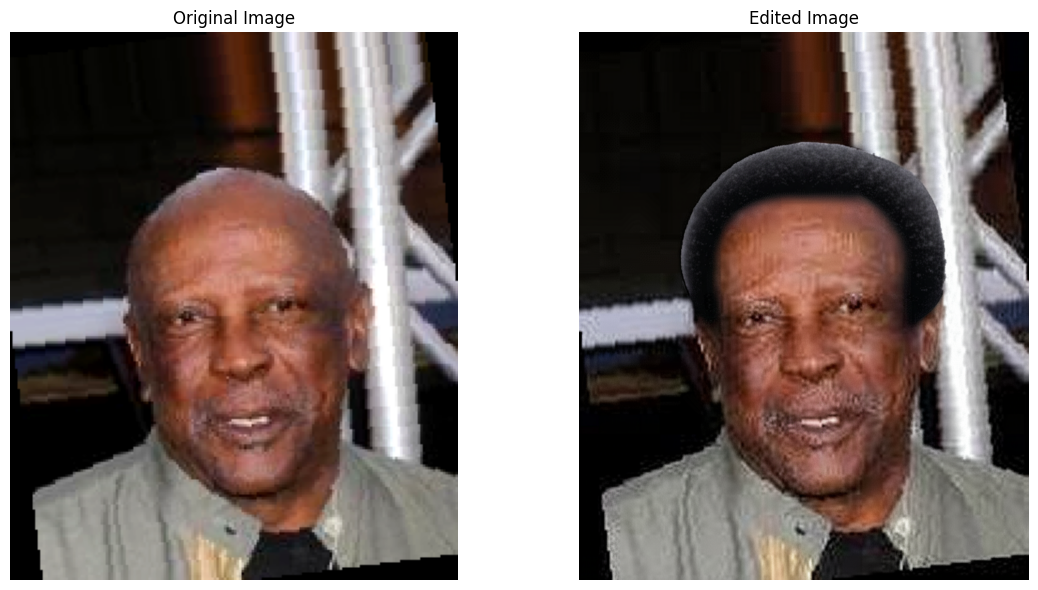

In [10]:
show_images(tensor_to_pil(bald_1), new_image)

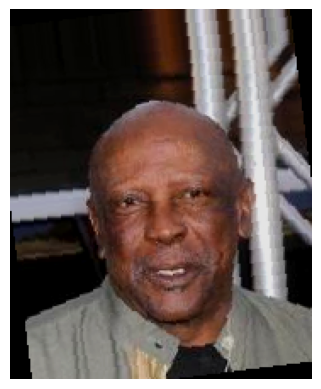

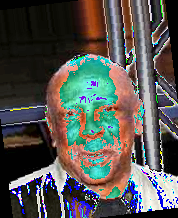

In [11]:
bald_1.shape
bald_pil = to_pil_image(bald_1)
bald_pil.show()
show_image(bald_1)
bald_pil

def to_pil(tensor):

    # Convert tensor to numpy, assuming tensor is in range [0, 1] and shape [C, H, W]
    tensor_np = tensor.cpu().detach().numpy()

    # Change from [C, H, W] to [H, W, C]
    tensor_np = tensor_np.transpose(1, 2, 0)

    # If needed, scale values from [0,1] to [0,255]
    tensor_np = (tensor_np * 255).astype('uint8')

    return Image.fromarray(tensor_np)

bald_pil2 = to_pil(bald_1)
bald_pil2

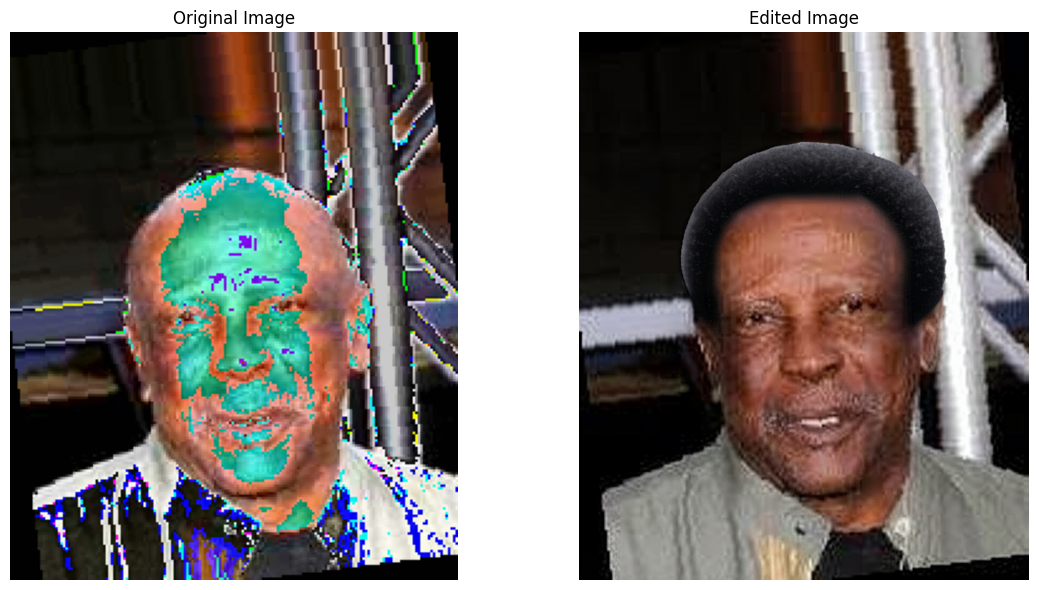

In [12]:
bald_pil = to_pil_image(bald_1)
show_images(bald_pil, new_image)


# Generate images to get rid of the bald people!

In [13]:
# 
name_to_ind

{'5_o_Clock_Shadow': 0,
 'Arched_Eyebrows': 1,
 'Attractive': 2,
 'Bags_Under_Eyes': 3,
 'Bald': 4,
 'Bangs': 5,
 'Big_Lips': 6,
 'Big_Nose': 7,
 'Black_Hair': 8,
 'Blond_Hair': 9,
 'Blurry': 10,
 'Brown_Hair': 11,
 'Bushy_Eyebrows': 12,
 'Chubby': 13,
 'Double_Chin': 14,
 'Eyeglasses': 15,
 'Goatee': 16,
 'Gray_Hair': 17,
 'Heavy_Makeup': 18,
 'High_Cheekbones': 19,
 'Male': 20,
 'Mouth_Slightly_Open': 21,
 'Mustache': 22,
 'Narrow_Eyes': 23,
 'No_Beard': 24,
 'Oval_Face': 25,
 'Pale_Skin': 26,
 'Pointy_Nose': 27,
 'Receding_Hairline': 28,
 'Rosy_Cheeks': 29,
 'Sideburns': 30,
 'Smiling': 31,
 'Straight_Hair': 32,
 'Wavy_Hair': 33,
 'Wearing_Earrings': 34,
 'Wearing_Hat': 35,
 'Wearing_Lipstick': 36,
 'Wearing_Necklace': 37,
 'Wearing_Necktie': 38,
 'Young': 39}

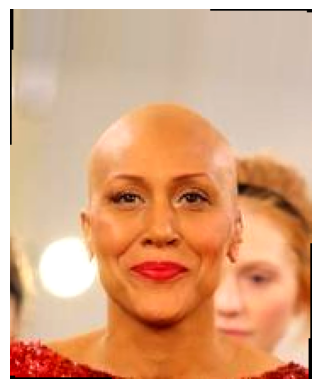

In [23]:

BASE_DIR = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/results")
EDITED_IMAGES_DIR = BASE_DIR / "edited_images"
EDITED_IMAGES_DIR.mkdir(parents=True, exist_ok=True)



mustache_indices = get_indices_by_attribute(name_to_ind["Mustache"])
bald_indices = get_indices_by_attribute(name_to_ind["Bald"])
male_indices = get_indices_by_attribute(name_to_ind["Male"])

bald_mask = (train_labels[:, name_to_ind["Bald"]] ==1)
female_mask = (train_labels[:, name_to_ind["Male"]] ==0)

# any male bald?

female_and_bald = (bald_mask & female_mask).nonzero(as_tuple=True)[0]
female_and_bald
# show image
show_image(train_dataset[female_and_bald[-3]][0])

text_input- Okay, here's a prompt designed for an image editor model, specifically targeting the removal of a "Rhino Horn" attribute while preserving the rest of the image:

**Prompt:**

"Edit the provided image to completely remove the rhino horn from the subject. The removal should be seamless, with no visible trace of the horn or its previous existence. The subject's head and the surrounding area should appear natural and undamaged after the removal, with the texture, color, and overall appearance of the subject's skin/hide/fur restored to a realistic and unharmed state. Pay careful attention to the details of the surrounding environment and ensure the edits blend naturally into the existing scene. The goal is a photorealistic and undetectable removal of the horn, leaving the subject unharmed and appearing as it would without one."

**Key elements and why they're included:**

*   **"Edit the provided image..."**: Clear and concise instruction.
*   **"...completely remove the rhino h

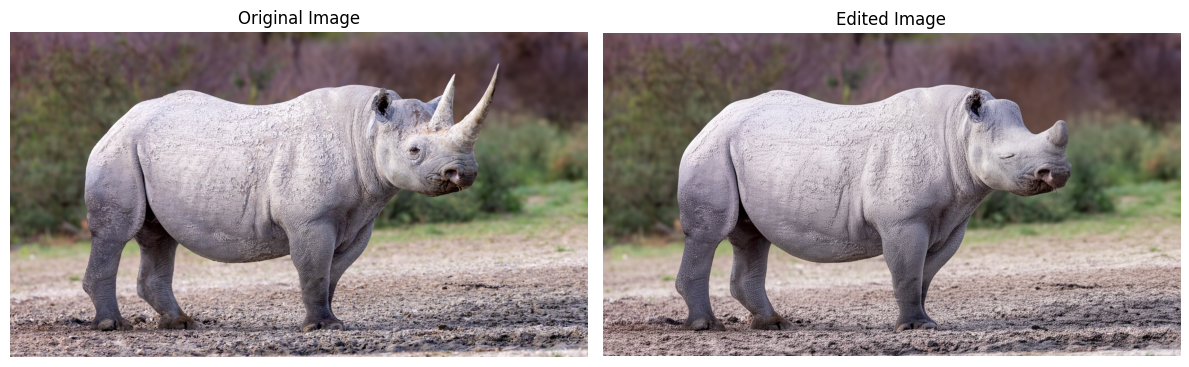

In [38]:
# write a prompt to edit an image which has attribute {index}, where we want to remove that attribute, an example is "Male". 

attribute = "Bald"
attribute = "Rhino Horn"

request = f"write a prompt for an image-editor model, in order to edit an image which has attribute '{attribute}', where we want to remove that attribute fully. There should be no evidence of a {attribute} afterwards but the being should be unharmed. " #, an example is 'Male'."

model = "models/gemini-2.0-flash-lite"
text_input = client.models.generate_content(
    model=model,
    contents=request,
).text
print(f"text_input- {text_input}")
new_rhino = edit_image(original_image, text_input)
show_images(original_image, new_rhino)


In [37]:
print(text_input)

Here's a prompt designed for an image editor, aiming to remove a rhino horn from an image while maintaining the integrity of the rhino:

**Prompt:**

"You are an expert image editor specializing in wildlife. The input image features a rhinoceros with a visible horn. Your task is to meticulously remove the rhinoceros's horn from the image. The goal is to achieve a completely seamless and realistic result. There should be no evidence of the horn's previous presence. Pay careful attention to the following details:

*   **Seamless Integration:** Blend the edited area with the surrounding skin and texture of the rhino's head and face. The color, pattern, and lighting should be consistent and natural. Avoid any unnatural smudging, blurring, or visible artifacts.
*   **Realistic Anatomy:** Ensure the rhino's head maintains its natural shape and proportions. The removal of the horn must not result in any deformities or distortions of the rhino's skull or face. Pay attention to the underlying m

In [52]:
len(bald_indices)

3713

In [62]:
index = female_and_bald[-3]
female_bald_image = train_dataset[index][0]
female_bald_image = tensor_to_pil(female_bald_image)
# remove mustache from image
import time 

text_input  = "This is an image of a bald person. Give them hair. \n The goal is to convincingly add hair to the subject's head, matching the subject's existing facial features, skin tone, and overall style. \nThe resulting image should appear as if the subject has a full head of hair that looks natural and blends seamlessly with the rest of the image, avoiding any noticeable artifacts or unnatural textures. Strive for a realistic and aesthetically pleasing outcome."

text_input = """ This image shows a person who is bald. Please realistically add hair to their head. There needs to be hair on their head! The final result should convincingly appear as if the person naturally has a full head of hair, enhancing the overall realism and aesthetic quality of the image. At the end, there needs to be hair on their head! More hair is better than less hair.
""" # 

text_input = """
This image shows a person who is bald. Please realistically add a full set of natural-looking hair to their head.\n
Guidelines:\n
* Match hair style, color, density, and texture to align seamlessly with the person's facial features, age, skin tone, and overall aesthetic.
* Ensure the hairline appears natural and blends smoothly with the existing forehead area.
* The final result should convincingly appear as if the person naturally has a full head of hair, enhancing the overall realism and aesthetic quality of the image.
At the end, there needs to be a full-set of hair on their head! More hair is better than less hair.
"""
print(f"text_input- {text_input}")
bald_indices = get_indices_by_attribute(name_to_ind["Bald"])

max_images = 1000

for ii, bald_index in tqdm(enumerate(bald_indices[:max_images])):
    
    bald_image = train_dataset[bald_index][0]
    bald_image = tensor_to_pil(bald_image)
    new_image = edit_image(bald_image, text_input)
    if (ii % 100 ==0 ) or (ii < 5):
       show_images(bald_image, new_image)
        # save image
    new_image.save(EDITED_IMAGES_DIR / f"edited_{bald_index}.png")
    # time sleep 8
    time.sleep(8)

#new_image.save(EDITED_IMAGES_DIR / f"edited_{index}.png")

text_input- 
This image shows a person who is bald. Please realistically add a full set of natural-looking hair to their head.

Guidelines:

* Match hair style, color, density, and texture to align seamlessly with the person's facial features, age, skin tone, and overall aesthetic.
* Ensure the hairline appears natural and blends smoothly with the existing forehead area.
* The final result should convincingly appear as if the person naturally has a full head of hair, enhancing the overall realism and aesthetic quality of the image.
At the end, there needs to be a full-set of hair on their head! More hair is better than less hair.



0it [00:00, ?it/s]

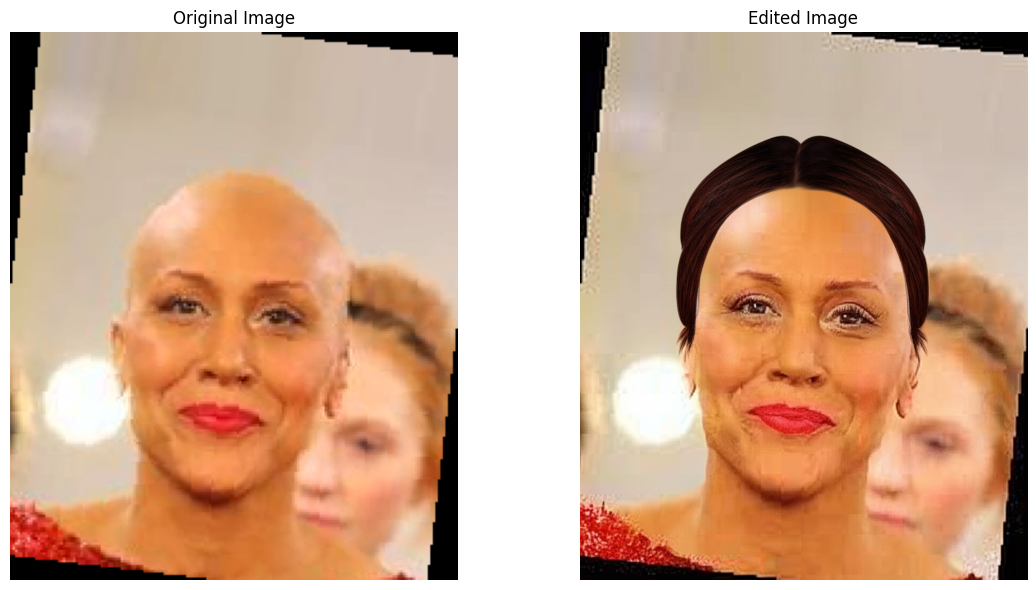

In [51]:

new_image = edit_image(female_bald_image, text_input_)
show_images(female_bald_image, new_image)


In [ ]:
### trying to be clever:
text_input = "This is a bald person, please give them hair on their head. Make sure the hair is realistic and blends in with the rest of the image."

attribute = "Bald"
request = f"write 1 single prompt for an image-editor model, in order to edit an image of a person which has attribute '{attribute}', where we want to remove that attribute fully. A sample prompt is '{text_input}'. Keep it to ~1-2 paragraph" #, an example is 'Male'."
text_input = client.models.generate_content(
    model=model,
    contents=request,
).text